In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import folium
from ipywidgets import interact, Dropdown

In [2]:
df = pd.read_csv(r'final_dataset_cleaned.csv', low_memory=False)

In [3]:
# Convert flag columns to ints (if they exist)
flag_cols = ['is_marine.1', 'is_freshwater.1', 'is_terrestrial.1', 'is_brackish.1', 'is_extinct.1']
for c in flag_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0).astype(int)

In [4]:
# Simple habitat label (one row may have multiple flags; this joins them)
def habitat_row(r):
    parts = []
    mapping = [('is_marine.1','marine'), ('is_freshwater.1','freshwater'),
               ('is_terrestrial.1','terrestrial'), ('is_brackish.1','brackish')]
    for col,label in mapping:
        if col in r.index and r[col] == 1:
            parts.append(label)
    return ','.join(parts) if parts else 'unknown'

In [5]:
df['habitat_simple'] = df.apply(habitat_row, axis=1)

In [6]:
# Compute centroid and range spans (if Easternmost/Westernmost/Northernmost/Southermost exist)
for c in ['Easternmost','Westernmost','Northernmost','Southermost']:
    if c not in df.columns:
        df[c] = np.nan

In [7]:
df['centroid_lon'] = df[['Easternmost','Westernmost']].mean(axis=1)
df['centroid_lat'] = df[['Northernmost','Southermost']].mean(axis=1)
df['range_lon_span'] = (df['Easternmost'] - df['Westernmost']).abs()
df['range_lat_span'] = (df['Northernmost'] - df['Southermost']).abs()
df['range_area_approx'] = df['range_lon_span'] * df['range_lat_span']  # rough degrees^2

In [8]:
# Parse 'modified' if present to extract year
if 'modified' in df.columns:
    df['modified'] = pd.to_datetime(df['modified'], errors='coerce')
    df['modified_year'] = df['modified'].dt.year

**Taxonomia Top 20 Families**

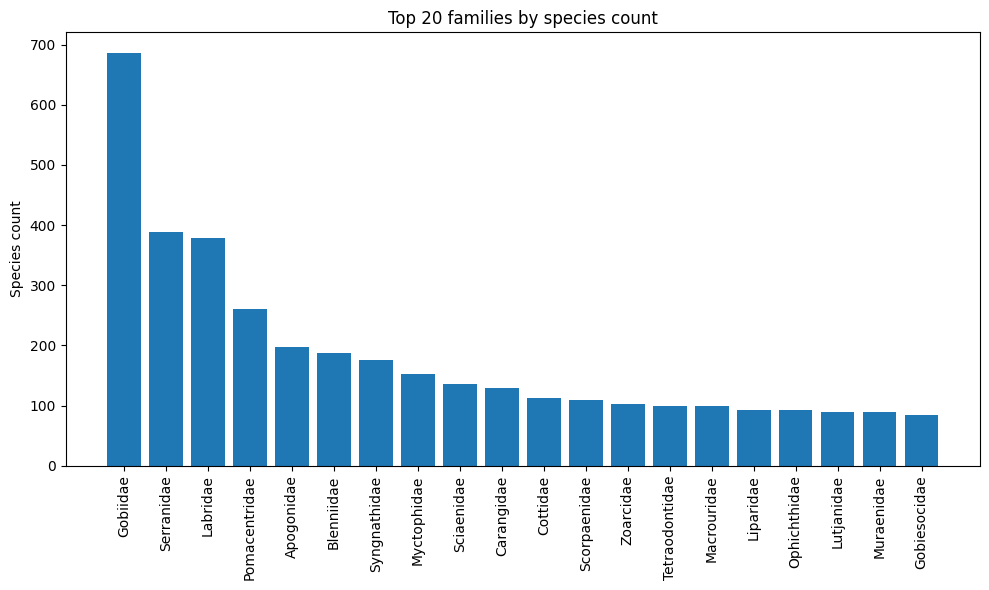

In [9]:
top_n = 20
if 'family' in df.columns:
    top_families = df['family'].value_counts().head(top_n)
    plt.figure(figsize=(10,6))
    plt.bar(range(len(top_families)), top_families.values, align='center')
    plt.xticks(range(len(top_families)), top_families.index, rotation=90)
    plt.title(f'Top {top_n} families by species count')
    plt.ylabel('Species count')
    plt.tight_layout()
    plt.show()
else:
    print("No 'family' column found.")

**Habitat Composition**

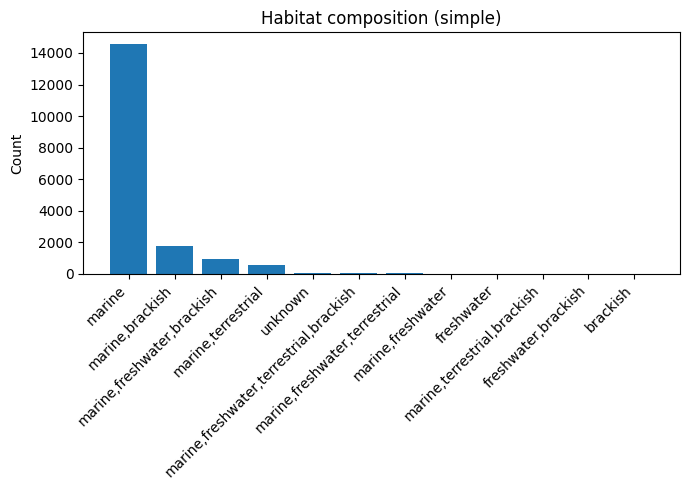

In [10]:
if 'habitat_simple' in df.columns:
    counts = df['habitat_simple'].value_counts()
    plt.figure(figsize=(7,5))
    plt.bar(counts.index, counts.values)
    plt.xticks(rotation=45, ha='right')
    plt.title('Habitat composition (simple)')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
else:
    print("No habitat columns found.")

**Vulnerability distribution**

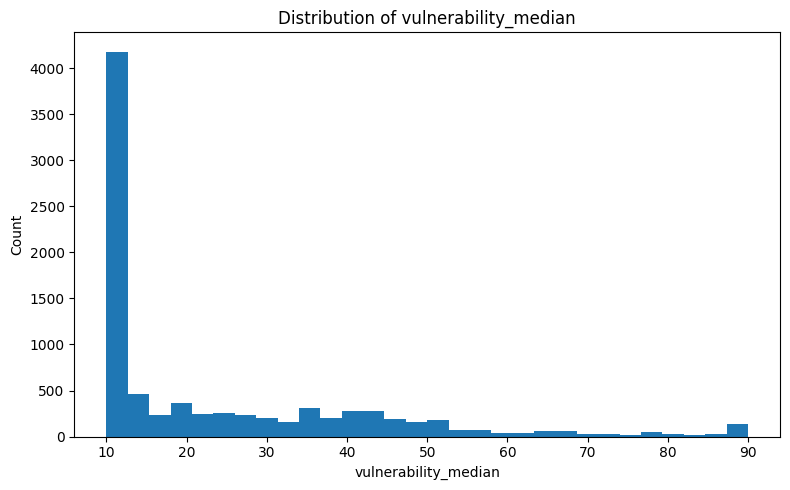

In [11]:
col = 'vulnerability_median'  # try vulnerability_min / max similarly
if col in df.columns:
    vals = df[col].dropna()
    plt.figure(figsize=(8,5))
    plt.hist(vals, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
else:
    print(f"{col} not found in the dataset.")

**Vulnerability by order for Top 10 Orders**

/tmp/ipython-input-1220341772.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=top_orders, showfliers=False)


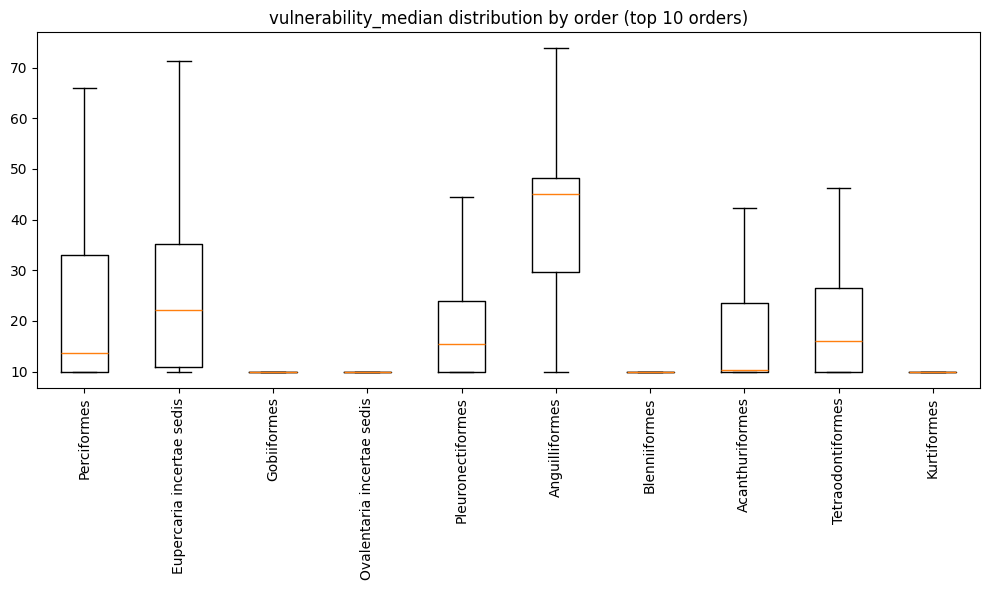

In [12]:
col = 'vulnerability_median'
if 'order' in df.columns and col in df.columns:
    top_orders = df['order'].value_counts().head(10).index.tolist()
    data = [df.loc[df['order'] == o, col].dropna() for o in top_orders]
    plt.figure(figsize=(10,6))
    plt.boxplot(data, labels=top_orders, showfliers=False)
    plt.xticks(rotation=90)
    plt.title(f'{col} distribution by order (top 10 orders)')
    plt.tight_layout()
    plt.show()
else:
    print("Either 'order' or vulnerability column not found.")

**Range area vs vulnerability (scatter)**

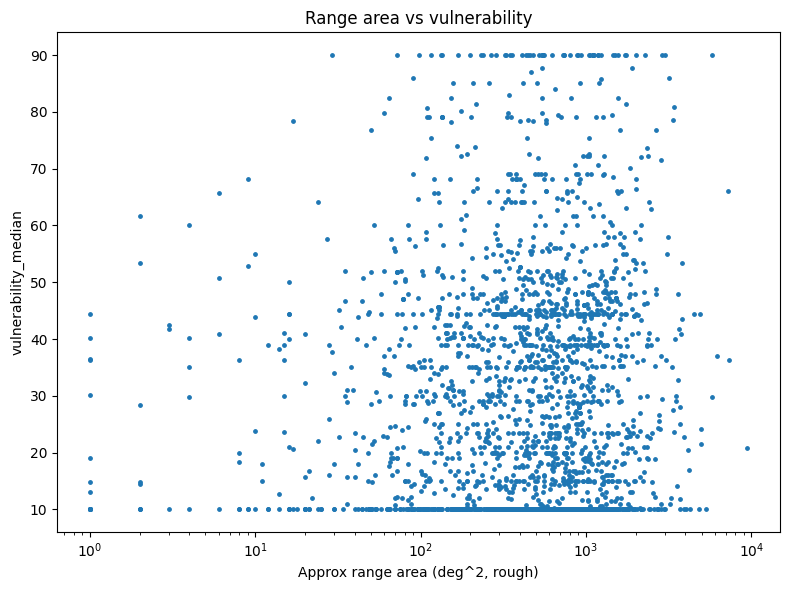

In [13]:
col = 'vulnerability_median'
if 'range_area_approx' in df.columns and col in df.columns:
    mask = df['range_area_approx'].notna() & df[col].notna()
    # sample if too many points
    s = df.loc[mask, ['range_area_approx', col]].sample(min(5000, mask.sum()), random_state=1)
    plt.figure(figsize=(8,6))
    plt.scatter(s['range_area_approx'], s[col], s=6)
    plt.xscale('log')  # optional; remove if you don't want log scale
    plt.xlabel('Approx range area (deg^2, rough)')
    plt.ylabel(col)
    plt.title('Range area vs vulnerability')
    plt.tight_layout()
    plt.show()
else:
    print("range_area_approx or vulnerability column missing.")

**Approximate centroid scatter (world-ish view)**

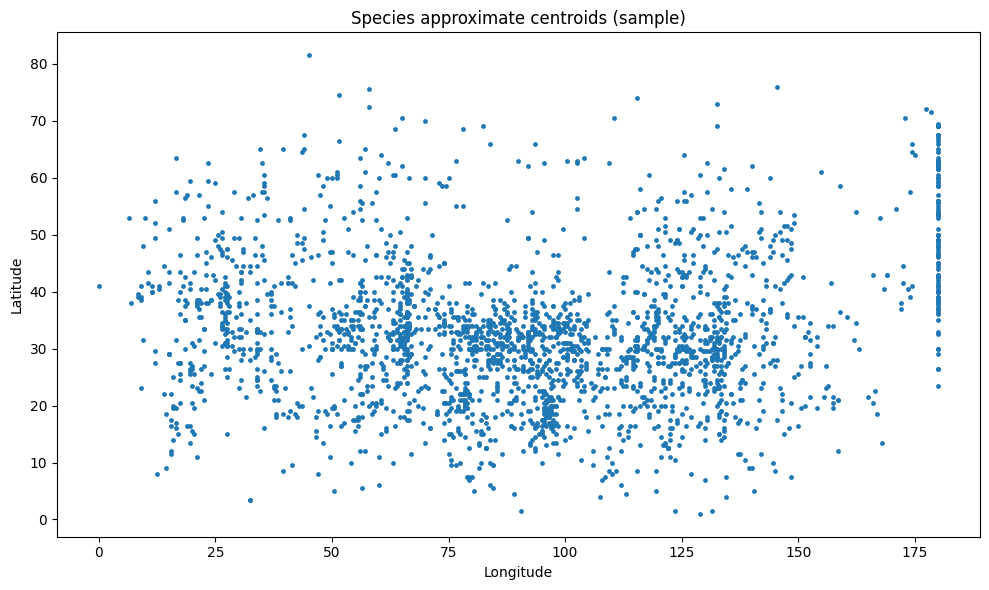

In [14]:
if 'centroid_lon' in df.columns and 'centroid_lat' in df.columns:
    mask = df['centroid_lon'].notna() & df['centroid_lat'].notna()
    sample = df.loc[mask].sample(min(5000, mask.sum()), random_state=1)
    plt.figure(figsize=(10,6))
    plt.scatter(sample['centroid_lon'], sample['centroid_lat'], s=6)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Species approximate centroids (sample)')
    plt.tight_layout()
    plt.show()
else:
    print("Centroid columns missing.")

**Numeric correlation matrix**

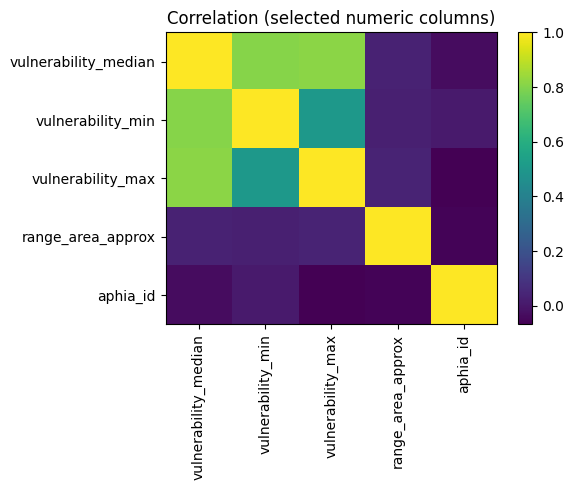

In [15]:
numeric_keys = []
for k in ['vulnerability_median','vulnerability_min','vulnerability_max','range_area_approx','aphia_id']:
    if k in df.columns:
        numeric_keys.append(k)

if numeric_keys:
    corr = df[numeric_keys].corr()
    plt.figure(figsize=(6,5))
    plt.imshow(corr, interpolation='nearest', aspect='auto')
    plt.colorbar()
    plt.xticks(range(len(numeric_keys)), numeric_keys, rotation=90)
    plt.yticks(range(len(numeric_keys)), numeric_keys)
    plt.title('Correlation (selected numeric columns)')
    plt.tight_layout()
    plt.show()
else:
    print("No suitable numeric columns for correlation preview.")

**Missingness map**

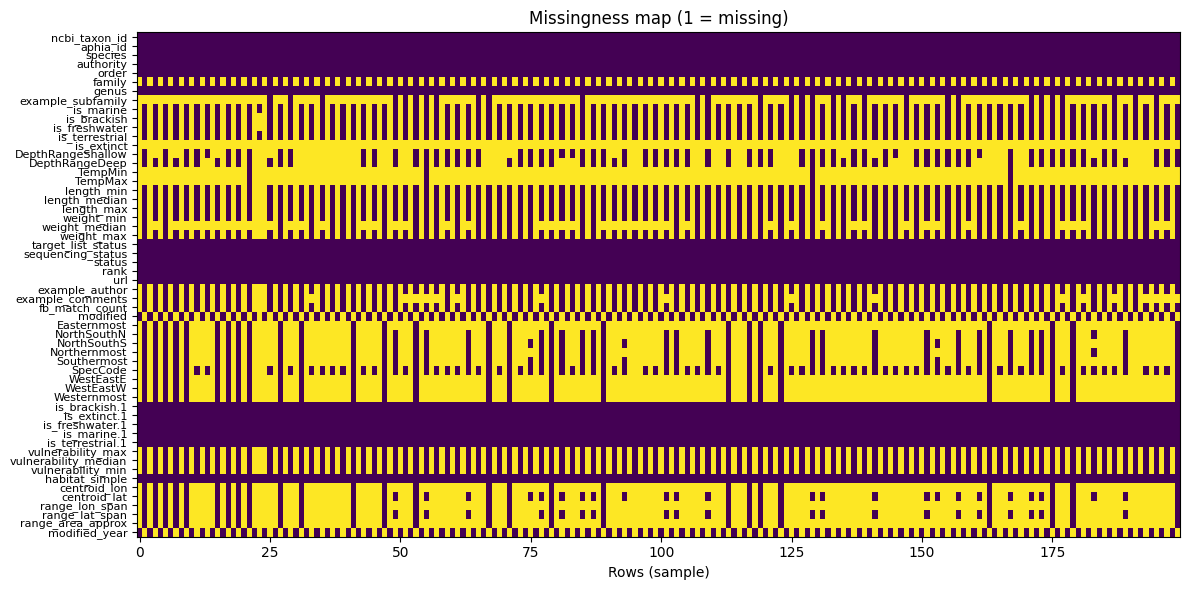

In [16]:
ms = df.isnull().astype(int)
#To keep image size reasonable show a subset of rows if necessary
nrows = min(200, df.shape[0])
ms_sample = ms.iloc[:nrows, :]  # first nrows rows shown
plt.figure(figsize=(12,6))
plt.imshow(ms_sample.T, aspect='auto')
plt.yticks(range(ms_sample.shape[1]), ms_sample.columns, fontsize=8)
plt.xlabel('Rows (sample)')
plt.title('Missingness map (1 = missing)')
plt.tight_layout()
plt.show()

In [26]:
# Ensure numeric columns for ranges
for col in ['Easternmost','Westernmost','Northernmost','Southermost']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [27]:
# Keep rows with valid geographic bounds
geo_df = df.dropna(subset=['Easternmost','Westernmost','Northernmost','Southermost'])

In [28]:
# Compute centroids for each record (approx. species region center)
geo_df['centroid_lat'] = (geo_df['Northernmost'] + geo_df['Southermost']) / 2
geo_df['centroid_lon'] = (geo_df['Easternmost'] + geo_df['Westernmost']) / 2

/tmp/ipython-input-1527769418.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_df['centroid_lat'] = (geo_df['Northernmost'] + geo_df['Southermost']) / 2
/tmp/ipython-input-1527769418.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_df['centroid_lon'] = (geo_df['Easternmost'] + geo_df['Westernmost']) / 2


In [29]:
# Dropdown options = species with valid points
species_options = sorted(geo_df['species'].dropna().unique().tolist())

In [30]:
def plot_species_points(species_name):
    subset = geo_df[geo_df['species'] == species_name]

    if subset.empty:
        print("No geographic data for this species")
        return

    # Center map on first occurrence
    m = folium.Map(
        location=[subset['centroid_lat'].iloc[0], subset['centroid_lon'].iloc[0]],
        zoom_start=3
    )

    # Add circles for each region where species appears
    for _, row in subset.iterrows():
        folium.Circle(
            location=[row['centroid_lat'], row['centroid_lon']],
            radius=500000,  # radius in meters (~500 km, adjust if needed)
            color="blue",
            fill=True,
            fill_opacity=0.4,
            tooltip=f"{species_name}\nLat: {row['centroid_lat']:.2f}, Lon: {row['centroid_lon']:.2f}"
        ).add_to(m)

    display(m)

In [32]:
# Interactive dropdown
interact(
    plot_species_points,
    species_name=Dropdown(options=species_options, description="Select Species:")
)

interactive(children=(Dropdown(description='Select Species:', options=('Abalistes stellatus', 'Abantennarius c…

<function __main__.plot_species_points(species_name)>